In [1]:
import pandas as ps

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import LinearSVC

from gensim import models

import warnings 
warnings.simplefilter('ignore')

from proj2_helpers import *
from get_embeddings_ML import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
from  word2vect_utilities import *

In [3]:
from nltk import word_tokenize, WordNetLemmatizer

### DATA LOADING

In [4]:
RESULT_POS_PATH = './Results/pp_pos_otpl_nd.txt'
RESULT_NEG_PATH = './Results/pp_neg_otpl_nd.txt'
RES_PATH = './Results/pp_test_otpl.txt'

In [5]:
# load the data files = list with each line being a tweet
result_pos = open(RESULT_POS_PATH, "r").read().splitlines()
result_neg = open(RESULT_NEG_PATH, "r").read().splitlines()
test_set = open(RES_PATH, "r").read().splitlines()

### DATAFRAME CONSTRUCTION

In [6]:
#-----------------------------------------TRAINING SET---------------------------------------------------------------------------

# create labels
label_pos = [1] * len(result_pos)
#create a df
pos_df = pd.DataFrame(list(zip(label_pos, result_pos)),columns=["Sentiment","Tweet"]) 
del label_pos

# create labels
label_neg = [-1] * len(result_neg)
# create a df
neg_df = pd.DataFrame(list(zip(label_neg, result_neg)),columns=["Sentiment","Tweet"]) #create a df
del label_neg

# regroup the dfs, ignore index in order to get new ones (->no duplicate)
train_df = pd.concat([pos_df,neg_df],ignore_index=True) #regroup the dfs, ignore index in order to get new ones (->no duplicate)

train_tokens = [word_tokenize(sen) for sen in train_df.Tweet] 

train_df['tokens'] = train_tokens

# shuffle the rows
train_df = train_df.sample(frac=1) 

In [7]:
train_df

,Sentiment,Tweet,tokens
129830,-1,man terrible way start day lose lanyard gym me...,"[man, terrible, way, start, day, lose, lanyard..."
68471,1,hair long long enough pull nice lil grip,"[hair, long, long, enough, pull, nice, lil, grip]"
57518,1,outline say get tired name mao okay,"[outline, say, get, tired, name, mao, okay]"
61605,1,see forever,"[see, forever]"
128157,-1,hate art stress yet continue work motivation,"[hate, art, stress, yet, continue, work, motiv..."
...,...,...,...
77545,1,one lunch could stop chuckle mustard onion,"[one, lunch, could, stop, chuckle, mustard, on..."
130880,-1,miss juice last night permission either ooh ba...,"[miss, juice, last, night, permission, either,..."
5987,1,buy cut bath suit world today reason saw tweet...,"[buy, cut, bath, suit, world, today, reason, s..."
66379,1,say right lunch break,"[say, right, lunch, break]"


In [8]:
#-----------------------------------------TEST SET---------------------------------------------------------------------------
test_ids = np.linspace(1,10000,10000, dtype=int)
# create a df
test_df = pd.DataFrame(list(zip(test_ids, test_set)), columns=["Tweet_submission_id","Tweet"]) 

test_tokens = [word_tokenize(sen) for sen in test_df.Tweet] 

test_df['tokens'] = test_tokens

### WORD EMBEDDING

In [9]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [10]:
all_training_words = [word for tokens in train_df["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in train_df["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

1199577 words total, with a vocabulary size of 42148
Max sentence length is 26


In [11]:
training_embeddings = get_word2vec_embeddings(word2vec, train_df, generate_missing=True)

In [33]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

#### Tokenize and Pad sequences

In [25]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(train_df["Tweet"].tolist())
training_sequences = tokenizer.texts_to_sequences(train_df["Tweet"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 42146 unique tokens.


In [34]:
train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [37]:
len(train_data[0])

50

In [27]:
len(train_word_index.items())

42146

In [38]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(42147, 300)


In [39]:
x_train = train_data

In [40]:
y_train = train_df.Sentiment.values

In [41]:
test_sequences = tokenizer.texts_to_sequences(test_df["Tweet"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

#### PCA 

In [57]:
scaler = MinMaxScaler(feature_range=[0, 1])
X_rescaled = scaler.fit_transform(x_train)
test_rescaled = scaler.fit_transform(test_data)

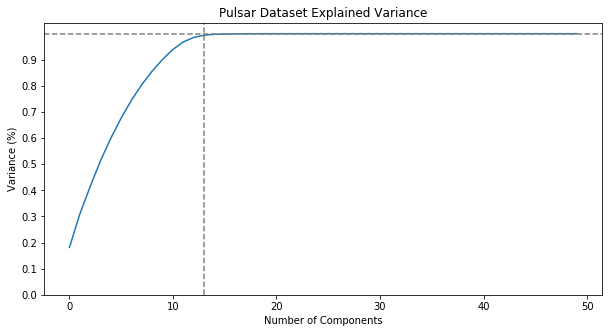

In [43]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
fig = plt.figure(figsize=(10,5))
x=np.cumsum(pca.explained_variance_ratio_)
plt.plot(x)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.yticks(np.arange(0, 1, 0.1))
plt.axhline(y=1,color='gray',linestyle='--')
plt.axvline(x=13,color='gray',linestyle='--')
plt.show()

We see that we have selecting 13 components we can preserve the total variance of the data.

In [44]:
pca = PCA(n_components=13)
train_vals = pca.fit_transform(X_rescaled)
test= pca.fit_transform(test_rescaled)

### LOGISTIC REGRESSION

In [58]:
# TRAIN LR ON WHOLE TRAINING SET
clf = linear_model.LogisticRegression(C=1e5,\
max_iter =10000,n_jobs=-1).fit(train_vals, y_train)
y_pred = clf.predict(test)

In [59]:
len(y_pred)

10000

### CREATE SUBMISSION

In [60]:
test_id = test_df['Tweet_submission_id'].to_numpy()

In [61]:
len(test_id)

10000

In [65]:
type(y_pred)

numpy.ndarray

In [62]:
create_csv_submission(test_id,y_pred, "./Submissions/W2V_LR_SUB.csv")